In [1]:
# Cell 2: Imports & CONFIG
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import math

# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# sklearn & viz
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

# CONFIG - Update these paths to match your environment
DATA_DIR = Path("/kaggle/input/betel/Controlled Environment")   # <-- change to your images root (folders per class)
IMAGE_INDEX_CSV = Path("/kaggle/working/image_index.csv")  # set if you have one, else leave
RESIZED_DIR = Path("resized_images")        # where resized images will be saved
TARGET_SIZE = (224, 224)                    # (width, height). set (128,128) for faster runs
BATCH_SIZE = 32
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)
print("DATA_DIR:", DATA_DIR)
print("IMAGE_INDEX_CSV:", IMAGE_INDEX_CSV)
print("RESIZED_DIR:", RESIZED_DIR)


Device: cuda
DATA_DIR: /kaggle/input/betel/Controlled Environment
IMAGE_INDEX_CSV: /kaggle/working/image_index.csv
RESIZED_DIR: resized_images


In [2]:
# Cell 3: EDA - folder structure & class counts
if DATA_DIR.exists():
    classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
    print("Found classes:", classes)
    counts = {}
    for cls in classes:
        cnt = sum(1 for _ in (DATA_DIR/cls).rglob("*") if _.is_file())
        counts[cls] = cnt
        print(f"  {cls}: {cnt} files")
else:
    classes = []
    counts = {}
    print("DATA_DIR not found. Make sure DATA_DIR path is correct.")

# quick dataframe for EDA
counts_df = pd.DataFrame(list(counts.items()), columns=['class','count']).sort_values('count', ascending=False)
counts_df


Found classes: ['Diseased', 'Dried', 'Healthy']
  Diseased: 220 files
  Dried: 340 files
  Healthy: 333 files


,class,count
1,Dried,340
2,Healthy,333
0,Diseased,220


In [3]:
# Cell 4: EDA - check for corrupted/unreadable images
bad_files = []
shapes = []   # list of (width, height)
samples = []  # save a few sample paths per class

if DATA_DIR.exists():
    total_checked = 0
    for cls in classes:
        cls_dir = DATA_DIR / cls
        sample_for_class = []
        for p in cls_dir.rglob('*'):
            if not p.is_file():
                continue
            total_checked += 1
            try:
                with Image.open(p) as img:
                    img.verify()  # verify only
                # reopen to get size
                with Image.open(p) as img2:
                    w,h = img2.size
                shapes.append((w,h))
                if len(sample_for_class) < 5:
                    sample_for_class.append(str(p))
            except Exception as e:
                bad_files.append((str(p), str(e)))
        samples.append((cls, sample_for_class))

    print("Total files checked:", total_checked)
    print("Corrupted/unreadable files found:", len(bad_files))
    if len(bad_files) > 0:
        for bf in bad_files[:10]:
            print(bf)
    else:
        print("No obvious corrupted files found (via PIL verify).")
else:
    print("DATA_DIR not found; can't check files.")


Total files checked: 893
Corrupted/unreadable files found: 0
No obvious corrupted files found (via PIL verify).


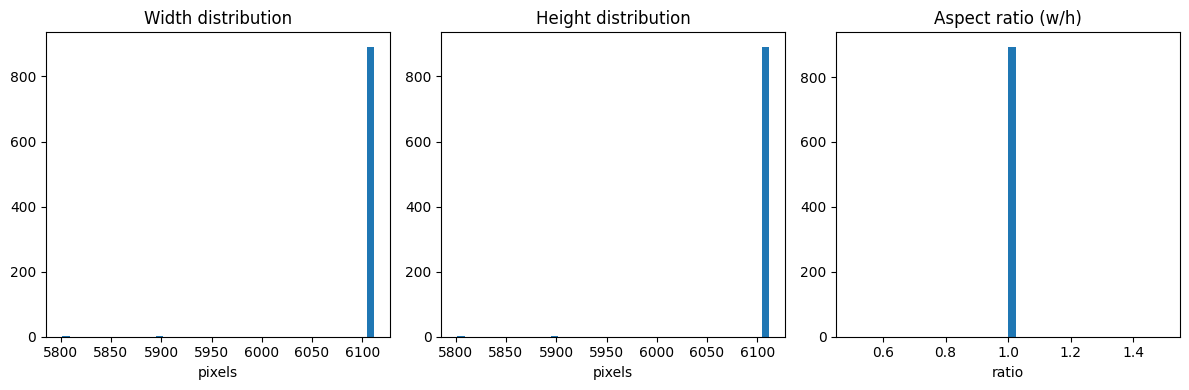

Width: min,median,max = 5801 6112.0 6112
Height: min,median,max = 5801 6112.0 6112
Aspect ratio: min,median,max = 1.0 1.0 1.0


In [4]:
# Cell 5: EDA - size and aspect ratio distributions
if len(shapes) == 0:
    print("No image shapes recorded. Maybe DATA_DIR not set or images unreadable.")
else:
    widths = [s[0] for s in shapes]
    heights = [s[1] for s in shapes]
    ratios = [w/h if h>0 else 0 for w,h in shapes]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.hist(widths, bins=40)
    plt.title("Width distribution")
    plt.xlabel("pixels")

    plt.subplot(1,3,2)
    plt.hist(heights, bins=40)
    plt.title("Height distribution")
    plt.xlabel("pixels")

    plt.subplot(1,3,3)
    plt.hist(ratios, bins=40)
    plt.title("Aspect ratio (w/h)")
    plt.xlabel("ratio")

    plt.tight_layout()
    plt.show()

    # print some summary stats
    print("Width: min,median,max =", min(widths), np.median(widths), max(widths))
    print("Height: min,median,max =", min(heights), np.median(heights), max(heights))
    print("Aspect ratio: min,median,max =", min(ratios), np.median(ratios), max(ratios))


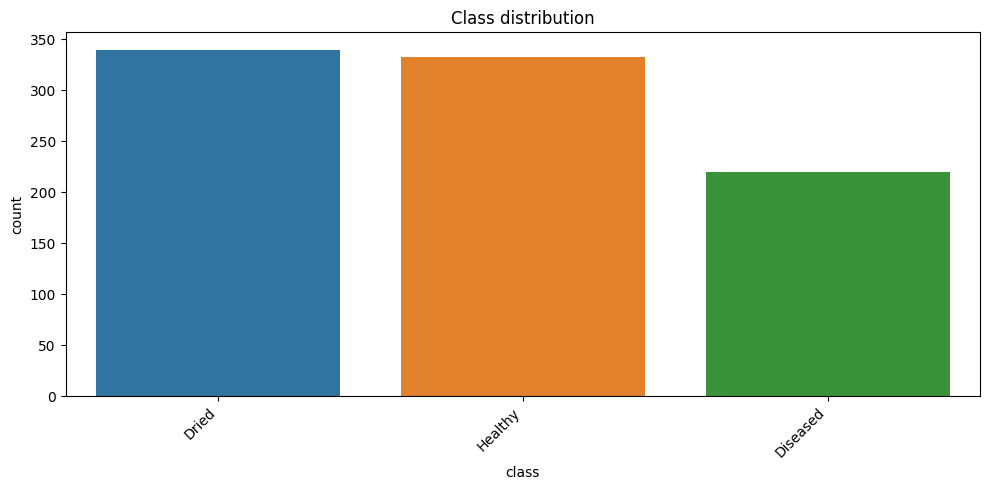

In [5]:
# Cell 6: EDA - class distribution bar chart
if len(counts_df) > 0:
    plt.figure(figsize=(10,5))
    sns.barplot(data=counts_df, x='class', y='count')
    plt.xticks(rotation=45, ha='right')
    plt.title("Class distribution")
    plt.tight_layout()
    plt.show()
else:
    print("No class count data to plot.")


Class: Diseased


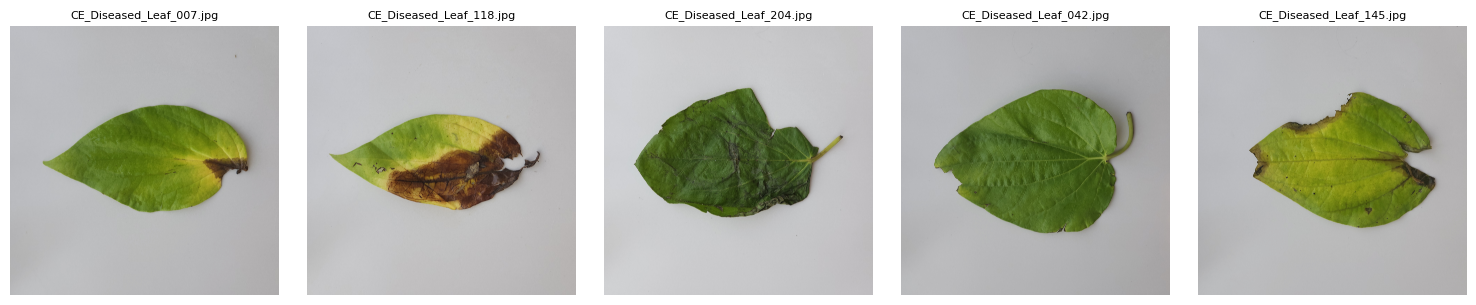

Class: Dried


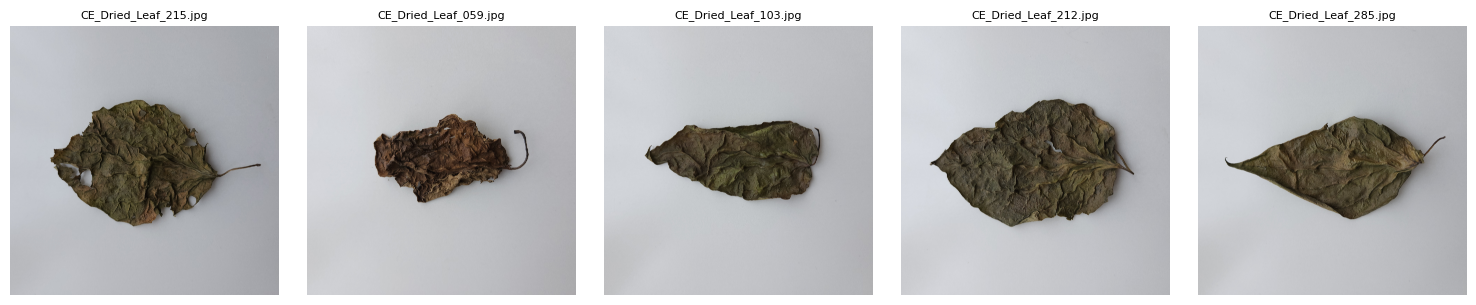

Class: Healthy


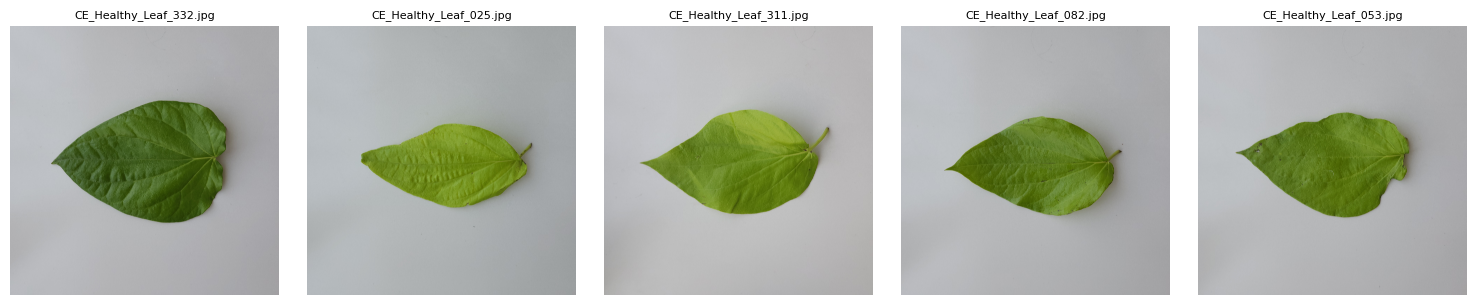

In [6]:
# Cell 7: EDA - show sample images per class (up to 5 per class)
def show_image_grid(image_paths, ncols=5, figsize=(15,3)):
    n = len(image_paths)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(figsize[0], figsize[1]*nrows))
    for i, p in enumerate(image_paths):
        try:
            img = Image.open(p).convert('RGB')
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(Path(p).name, fontsize=8)
        except Exception as e:
            plt.subplot(nrows, ncols, i+1)
            plt.text(0.5,0.5, "err", ha='center')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# display samples (limit to first 6 classes)
for cls, sample_list in samples[:6]:
    if len(sample_list) == 0:
        continue
    print("Class:", cls)
    show_image_grid(sample_list, ncols=5, figsize=(15,3))


In [7]:
# Cell 8: Build / load image index CSV (optional)
if IMAGE_INDEX_CSV.exists():
    df = pd.read_csv(IMAGE_INDEX_CSV)
    print("Loaded image index:", IMAGE_INDEX_CSV, "rows:", len(df))
else:
    rows = []
    if DATA_DIR.exists():
        for cls_dir in sorted([d for d in DATA_DIR.iterdir() if d.is_dir()]):
            for img_path in cls_dir.rglob('*'):
                if img_path.is_file():
                    rows.append({'filepath': str(img_path.resolve()), 'class': cls_dir.name})
        df = pd.DataFrame(rows)
        df.to_csv("image_index_generated.csv", index=False)
        print("Generated image_index_generated.csv with", len(df), "rows")
    else:
        df = pd.DataFrame(columns=['filepath','class'])
        print("No data found to index. Please set DATA_DIR correctly.")
df.head()


Generated image_index_generated.csv with 893 rows


,filepath,class
0,/kaggle/input/betel/Controlled Environment/Dis...,Diseased
1,/kaggle/input/betel/Controlled Environment/Dis...,Diseased
2,/kaggle/input/betel/Controlled Environment/Dis...,Diseased
3,/kaggle/input/betel/Controlled Environment/Dis...,Diseased
4,/kaggle/input/betel/Controlled Environment/Dis...,Diseased


In [8]:
# Cell 9: RESIZE & cache images
RESIZED_DIR.mkdir(parents=True, exist_ok=True)
print('Resizing to', TARGET_SIZE, '->', RESIZED_DIR)

skipped = 0
failed = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    src = Path(row['filepath'])
    cls = row['class']
    if not src.exists():
        skipped += 1
        continue
    dst_dir = RESIZED_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst = dst_dir / src.name
    if dst.exists():
        continue  # skip if already resized
    try:
        with Image.open(src) as img:
            img = img.convert('RGB')
            # Optional: pad to square to preserve aspect ratio
            # max_side = max(img.size)
            # img = ImageOps.pad(img, (max_side, max_side), color=(0,0,0))
            img = img.resize(TARGET_SIZE, Image.BILINEAR)
            img.save(dst)
    except Exception as e:
        failed.append((str(src), str(e)))

print("Done. Resized images are in:", RESIZED_DIR)
print("Skipped (missing):", skipped, "Failed:", len(failed))
if len(failed) > 0:
    print("First failed examples:", failed[:5])


Resizing to (224, 224) -> resized_images


100%|██████████| 893/893 [08:13<00:00,  1.81it/s]

Done. Resized images are in: resized_images
Skipped (missing): 0 Failed: 0


In [9]:
# Cell 10: Create train/val/test splits from RESIZED_DIR
res_df_rows = []
for cls_dir in sorted([d for d in RESIZED_DIR.iterdir() if d.is_dir()]):
    for p in cls_dir.rglob('*'):
        if p.is_file():
            res_df_rows.append({'filepath': str(p.resolve()), 'class': cls_dir.name})
res_df = pd.DataFrame(res_df_rows)
print("Total resized images:", len(res_df))

# default split (approx 81:9:10) — but we'll use res_df later for custom ratios
trainval, test = train_test_split(res_df, test_size=0.10, stratify=res_df['class'], random_state=42)
train, val = train_test_split(trainval, test_size=0.11, stratify=trainval['class'], random_state=42)  # ~10% val

train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

print("Saved default CSVs -> train:", len(train), "val:", len(val), "test:", len(test))


Total resized images: 893
Saved default CSVs -> train: 714 val: 89 test: 90


In [13]:
# Cell 11: Dataset & DataLoader helper
class ImageCSVLoader(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.df['class'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[row['class']]
        return img, label

# Transforms (images already resized)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


In [14]:
# Cell 12: Model definition helper (function to create fresh ResNet50)
def make_resnet50(num_classes, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [15]:
# Cell 13: Training & evaluation functions (single-run)
def train_one_epoch(model, dl, opt, crit):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in tqdm(dl):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        opt.zero_grad()
        outputs = model(imgs)
        loss = crit(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds==labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

def evaluate(model, dl, crit=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for imgs, labels in dl:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            if crit is not None:
                loss = crit(outputs, labels)
                running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    avg_loss = running_loss/total if crit is not None and total>0 else None
    acc = correct/total if total>0 else 0.0
    return avg_loss, acc, y_true, y_pred


In [16]:
# Cell 14: Load default best model (if you saved) and evaluate test.csv example
# This is optional example if you trained earlier and saved a model to best_model.pth
if Path("best_model.pth").exists():
    # prepare test loader
    test_ds = ImageCSVLoader("test.csv", transform=eval_transforms)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    num_classes = len(test_ds.classes)
    model = make_resnet50(num_classes, pretrained=False)
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
    model = model.to(DEVICE)
    _, acc, y_true, y_pred = evaluate(model, test_dl)
    print("Test accuracy:", acc)
    print(skm.classification_report(y_true, y_pred, target_names=test_ds.classes, zero_division=0))
else:
    print("No best_model.pth found — skip this demo eval or train first.")


No best_model.pth found — skip this demo eval or train first.


In [17]:
# Cell 15: Confusion matrix visualization (requires y_true, y_pred from last eval)
# Run this after you have y_true, y_pred from an evaluation
try:
    cm = skm.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ds.classes, yticklabels=test_ds.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("No y_true/y_pred available yet. Run an evaluation first.", e)


No y_true/y_pred available yet. Run an evaluation first. name 'y_true' is not defined


In [19]:
# Cell 16: Run 9 ratio experiments with ResNet50 + Metrics summary
# WARNING: This will run ResNet50 multiple times. Keep EPOCHS small (e.g., 2-4) unless you have time/GPU.

from sklearn.metrics import precision_score, recall_score, f1_score

# Ratios = fraction for train+val (we will split off test as 1-r)
RATIOS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
EPOCHS = 40   # change to 2 for fast runs, or 5+ for better performance
VAL_RATIO = 0.10  # fraction of trainval used as validation (stratified)
USE_PRETRAINED = True  # set False if you want random init (slower convergence)

# Prepare a place to store results
results = []

# We'll use res_df (created in Cell 10) as the full dataset (resized images)
if 'res_df' not in globals():
    raise RuntimeError("res_df not found. Run Cell 10 (create resized images and res_df) before Cell 16.")

# For reproducibility
RANDOM_STATE = 42

for ratio in RATIOS:
    print(f"\n===== Running ratio {int(ratio*100)}:{int((1-ratio)*100)} =====")
    # Stratified split: trainval vs test
    trainval_df, test_df = train_test_split(res_df, test_size=(1-ratio), stratify=res_df['class'], random_state=RANDOM_STATE)

    # Further split trainval -> train & val (stratified)
    train_df, val_df = train_test_split(trainval_df, test_size=VAL_RATIO, stratify=trainval_df['class'], random_state=RANDOM_STATE)

    # Save temp CSVs
    train_df.to_csv("train_temp.csv", index=False)
    val_df.to_csv("val_temp.csv", index=False)
    test_df.to_csv("test_temp.csv", index=False)

    # Datasets & loaders
    train_ds = ImageCSVLoader("train_temp.csv", transform=train_transforms)
    val_ds = ImageCSVLoader("val_temp.csv", transform=eval_transforms)
    test_ds = ImageCSVLoader("test_temp.csv", transform=eval_transforms)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    num_classes = len(train_ds.classes)
    print("Num classes:", num_classes, "| Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

    # Build model
    model = make_resnet50(num_classes, pretrained=USE_PRETRAINED)
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train for EPOCHS
    best_val_acc = 0.0
    best_model_state = None
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_one_epoch(model, train_dl, optimizer, criterion)
        _, val_acc, _, _ = evaluate(model, val_dl, criterion)
        print(f"Epoch {epoch}/{EPOCHS} — train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")
        # track best on val
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {k:v.cpu() for k,v in model.state_dict().items()}  # save CPU copy

    # Load best model (if any) for final test eval
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        model = model.to(DEVICE)

    # Evaluate on test set
    _, test_acc, y_true, y_pred = evaluate(model, test_dl)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"✅ Ratio {int(ratio*100)}:{int((1-ratio)*100)} | Test Acc={test_acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

    results.append({
        "TrainFraction": ratio,
        "TrainPct": int(ratio*100),
        "TestPct": int((1-ratio)*100),
        "TrainCount": len(train_df),
        "ValCount": len(val_df),
        "TestCount": len(test_df),
        "Accuracy": test_acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

# Summary DataFrame
results_df = pd.DataFrame(results)
print("\n=== Summary of all ratios ===")
display(results_df)

# Save results
results_df.to_csv("results_resnet50_ratios.csv", index=False)
print("Saved results_resnet50_ratios.csv")



===== Running ratio 10:90 =====
Num classes: 3 | Train: 80 Val: 9 Test: 804


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 1/40 — train_acc=0.6500 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch 2/40 — train_acc=0.9125 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 3/40 — train_acc=0.9500 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch 4/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 5/40 — train_acc=0.9750 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 6/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 7/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch 8/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch 9/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 10/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 11/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch 12/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch 13/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 14/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Epoch 15/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch 16/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch 17/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch 18/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 19/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 20/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch 21/40 — train_acc=0.9750 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 22/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch 23/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 24/40 — train_acc=0.9750 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 25/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 26/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch 27/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch 28/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch 29/40 — train_acc=1.0000 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 30/40 — train_acc=1.0000 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 31/40 — train_acc=1.0000 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 32/40 — train_acc=1.0000 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 33/40 — train_acc=1.0000 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch 34/40 — train_acc=1.0000 | val_acc=0.7778


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch 35/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch 36/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 37/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch 38/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch 39/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch 40/40 — train_acc=1.0000 | val_acc=0.8889
✅ Ratio 10:90 | Test Acc=0.8507 | Prec=0.8935 | Rec=0.7991 | F1=0.7993

===== Running ratio 20:80 =====
Num classes: 3 | Train: 160 Val: 18 Test: 715


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 1/40 — train_acc=0.7312 | val_acc=0.7778


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 2/40 — train_acc=0.9563 | val_acc=0.8333


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Epoch 3/40 — train_acc=0.9812 | val_acc=0.8333


100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 4/40 — train_acc=0.9437 | val_acc=0.8333


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 5/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 6/40 — train_acc=0.9812 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 7/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 8/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 9/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 10/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 11/40 — train_acc=0.9875 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 12/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 13/40 — train_acc=0.9750 | val_acc=0.9444


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 14/40 — train_acc=1.0000 | val_acc=0.9444


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 15/40 — train_acc=0.9875 | val_acc=0.9444


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 16/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 17/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 18/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 19/40 — train_acc=1.0000 | val_acc=0.9444


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 20/40 — train_acc=1.0000 | val_acc=0.9444


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 21/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 22/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 23/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 24/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 25/40 — train_acc=0.9812 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 26/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 27/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 28/40 — train_acc=0.9938 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 29/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 30/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 31/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 32/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 33/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 34/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 35/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 36/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 37/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 38/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 39/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 40/40 — train_acc=1.0000 | val_acc=0.8889
✅ Ratio 20:80 | Test Acc=0.8993 | Prec=0.9015 | Rec=0.9091 | F1=0.8932

===== Running ratio 30:70 =====
Num classes: 3 | Train: 240 Val: 27 Test: 626


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 1/40 — train_acc=0.7583 | val_acc=0.7778


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 2/40 — train_acc=0.9542 | val_acc=0.8148


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 3/40 — train_acc=0.9542 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 4/40 — train_acc=0.9500 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 5/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


Epoch 6/40 — train_acc=0.9750 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 7/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 8/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 9/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


Epoch 10/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 11/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 12/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


Epoch 13/40 — train_acc=1.0000 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 14/40 — train_acc=0.9958 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 15/40 — train_acc=0.9958 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 16/40 — train_acc=0.9958 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 17/40 — train_acc=0.9875 | val_acc=0.7407


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 18/40 — train_acc=0.9792 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Epoch 19/40 — train_acc=0.9917 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 20/40 — train_acc=0.9792 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 21/40 — train_acc=0.9708 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 22/40 — train_acc=0.9958 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 23/40 — train_acc=0.9958 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 24/40 — train_acc=0.9750 | val_acc=0.8889


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 25/40 — train_acc=0.9958 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


Epoch 26/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 27/40 — train_acc=0.9958 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 28/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 29/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 30/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 31/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


Epoch 32/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 33/40 — train_acc=0.9958 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 34/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 35/40 — train_acc=0.9917 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 36/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 37/40 — train_acc=0.9958 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 38/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 39/40 — train_acc=1.0000 | val_acc=0.9259


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 40/40 — train_acc=1.0000 | val_acc=0.9259
✅ Ratio 30:70 | Test Acc=0.9696 | Prec=0.9714 | Rec=0.9612 | F1=0.9654

===== Running ratio 40:60 =====
Num classes: 3 | Train: 321 Val: 36 Test: 536


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 1/40 — train_acc=0.8006 | val_acc=0.8056


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 2/40 — train_acc=0.9221 | val_acc=0.9167


100%|██████████| 11/11 [00:04<00:00,  2.67it/s]


Epoch 3/40 — train_acc=0.9626 | val_acc=0.9444


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 4/40 — train_acc=0.9751 | val_acc=0.9444


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 5/40 — train_acc=0.9502 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 6/40 — train_acc=0.9969 | val_acc=0.9444


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 7/40 — train_acc=0.9875 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 8/40 — train_acc=1.0000 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 9/40 — train_acc=0.9938 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 10/40 — train_acc=0.9938 | val_acc=0.9444


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 11/40 — train_acc=0.9813 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 12/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 13/40 — train_acc=1.0000 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 14/40 — train_acc=0.9907 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 15/40 — train_acc=0.9907 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 16/40 — train_acc=0.9938 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 17/40 — train_acc=0.9938 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 18/40 — train_acc=0.9907 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 19/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 20/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 21/40 — train_acc=1.0000 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 22/40 — train_acc=0.9875 | val_acc=0.9444


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 23/40 — train_acc=0.9969 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 24/40 — train_acc=1.0000 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 25/40 — train_acc=0.9938 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 26/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 27/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 28/40 — train_acc=1.0000 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 29/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 30/40 — train_acc=0.9938 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 31/40 — train_acc=1.0000 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 32/40 — train_acc=0.9938 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 33/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 34/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 35/40 — train_acc=0.9969 | val_acc=0.9722


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 36/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 37/40 — train_acc=0.9720 | val_acc=0.8889


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 38/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 39/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 40/40 — train_acc=0.9969 | val_acc=0.9722
✅ Ratio 40:60 | Test Acc=0.9720 | Prec=0.9710 | Rec=0.9666 | F1=0.9684

===== Running ratio 50:50 =====
Num classes: 3 | Train: 401 Val: 45 Test: 447


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Epoch 1/40 — train_acc=0.8055 | val_acc=0.8222


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 2/40 — train_acc=0.9626 | val_acc=0.8000


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 3/40 — train_acc=0.9825 | val_acc=0.9111


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 4/40 — train_acc=0.9925 | val_acc=0.9111


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 5/40 — train_acc=0.9900 | val_acc=0.9111


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 6/40 — train_acc=0.9900 | val_acc=0.9556


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


Epoch 7/40 — train_acc=0.9950 | val_acc=0.9111


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 8/40 — train_acc=0.9950 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 9/40 — train_acc=0.9975 | val_acc=0.9556


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 10/40 — train_acc=0.9875 | val_acc=0.9778


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 11/40 — train_acc=0.9950 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 12/40 — train_acc=0.9950 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 13/40 — train_acc=1.0000 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 14/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 15/40 — train_acc=0.9925 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 16/40 — train_acc=0.9900 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 17/40 — train_acc=0.9925 | val_acc=0.9778


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 18/40 — train_acc=1.0000 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 19/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 20/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 21/40 — train_acc=1.0000 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 22/40 — train_acc=0.9975 | val_acc=0.9556


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


Epoch 23/40 — train_acc=0.9950 | val_acc=0.9778


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 24/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 25/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 26/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 27/40 — train_acc=1.0000 | val_acc=0.9778


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 28/40 — train_acc=0.9975 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 29/40 — train_acc=0.9975 | val_acc=0.9556


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 30/40 — train_acc=0.9975 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 31/40 — train_acc=0.9850 | val_acc=0.9556


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 32/40 — train_acc=0.9925 | val_acc=0.9778


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 33/40 — train_acc=0.9950 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 34/40 — train_acc=0.9925 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 35/40 — train_acc=1.0000 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 36/40 — train_acc=1.0000 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 37/40 — train_acc=1.0000 | val_acc=0.9556


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


Epoch 38/40 — train_acc=1.0000 | val_acc=0.9111


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 39/40 — train_acc=0.9950 | val_acc=0.9333


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 40/40 — train_acc=0.9975 | val_acc=0.9556
✅ Ratio 50:50 | Test Acc=0.9821 | Prec=0.9820 | Rec=0.9779 | F1=0.9798

===== Running ratio 60:40 =====
Num classes: 3 | Train: 481 Val: 54 Test: 358


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 1/40 — train_acc=0.8316 | val_acc=0.9259


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 2/40 — train_acc=0.9584 | val_acc=0.9074


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 3/40 — train_acc=0.9688 | val_acc=0.8148


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 4/40 — train_acc=0.9813 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 5/40 — train_acc=0.9543 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 6/40 — train_acc=0.9813 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 7/40 — train_acc=0.9917 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 8/40 — train_acc=0.9958 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 9/40 — train_acc=0.9938 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 10/40 — train_acc=0.9958 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 11/40 — train_acc=0.9938 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 12/40 — train_acc=0.9938 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 13/40 — train_acc=0.9958 | val_acc=1.0000


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 14/40 — train_acc=0.9938 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Epoch 15/40 — train_acc=0.9938 | val_acc=0.9259


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 16/40 — train_acc=0.9958 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Epoch 17/40 — train_acc=0.9917 | val_acc=1.0000


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 18/40 — train_acc=0.9938 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 19/40 — train_acc=0.9896 | val_acc=1.0000


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 20/40 — train_acc=0.9979 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch 21/40 — train_acc=0.9938 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Epoch 22/40 — train_acc=0.9938 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 23/40 — train_acc=0.9958 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 24/40 — train_acc=0.9958 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 25/40 — train_acc=0.9958 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Epoch 26/40 — train_acc=0.9958 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Epoch 27/40 — train_acc=0.9979 | val_acc=1.0000


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 28/40 — train_acc=0.9938 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


Epoch 29/40 — train_acc=1.0000 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 30/40 — train_acc=0.9958 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch 31/40 — train_acc=0.9979 | val_acc=0.9259


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch 32/40 — train_acc=0.9979 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 33/40 — train_acc=0.9917 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 34/40 — train_acc=0.9917 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch 35/40 — train_acc=0.9917 | val_acc=0.9815


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 36/40 — train_acc=0.9938 | val_acc=0.9074


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 37/40 — train_acc=0.9979 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 38/40 — train_acc=0.9958 | val_acc=0.9444


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 39/40 — train_acc=0.9958 | val_acc=0.9630


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 40/40 — train_acc=0.9979 | val_acc=0.9444
✅ Ratio 60:40 | Test Acc=0.9749 | Prec=0.9771 | Rec=0.9672 | F1=0.9714

===== Running ratio 70:30 =====
Num classes: 3 | Train: 562 Val: 63 Test: 268


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 1/40 — train_acc=0.8683 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 2/40 — train_acc=0.9680 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 3/40 — train_acc=0.9804 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 4/40 — train_acc=0.9875 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 5/40 — train_acc=0.9947 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 6/40 — train_acc=0.9786 | val_acc=0.9683


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 7/40 — train_acc=0.9875 | val_acc=0.9683


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 8/40 — train_acc=0.9911 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 9/40 — train_acc=0.9929 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 10/40 — train_acc=0.9982 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 11/40 — train_acc=0.9911 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 12/40 — train_acc=0.9911 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 13/40 — train_acc=0.9911 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 14/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 15/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 16/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 17/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Epoch 18/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 19/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 20/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


Epoch 21/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 22/40 — train_acc=1.0000 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 23/40 — train_acc=0.9982 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 24/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


Epoch 25/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 26/40 — train_acc=1.0000 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 27/40 — train_acc=0.9982 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 28/40 — train_acc=0.9947 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 29/40 — train_acc=0.9875 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 30/40 — train_acc=0.9911 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


Epoch 31/40 — train_acc=0.9929 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 32/40 — train_acc=0.9893 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 33/40 — train_acc=0.9929 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 34/40 — train_acc=0.9893 | val_acc=0.9206


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 35/40 — train_acc=0.9893 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 36/40 — train_acc=0.9893 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 37/40 — train_acc=0.9893 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 38/40 — train_acc=0.9893 | val_acc=1.0000


100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 39/40 — train_acc=0.9875 | val_acc=0.9841


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 40/40 — train_acc=0.9929 | val_acc=0.9841
✅ Ratio 70:30 | Test Acc=0.9776 | Prec=0.9737 | Rec=0.9766 | F1=0.9750

===== Running ratio 80:19 =====
Num classes: 3 | Train: 642 Val: 72 Test: 179


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 1/40 — train_acc=0.8692 | val_acc=0.9583


100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


Epoch 2/40 — train_acc=0.9642 | val_acc=0.8889


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 3/40 — train_acc=0.9704 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 4/40 — train_acc=0.9502 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 5/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


Epoch 6/40 — train_acc=0.9860 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 7/40 — train_acc=0.9922 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 8/40 — train_acc=0.9813 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Epoch 9/40 — train_acc=0.9782 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 10/40 — train_acc=0.9782 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


Epoch 11/40 — train_acc=0.9891 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 12/40 — train_acc=0.9813 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 13/40 — train_acc=0.9813 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 14/40 — train_acc=0.9907 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Epoch 15/40 — train_acc=0.9891 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 16/40 — train_acc=0.9938 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 17/40 — train_acc=0.9984 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 18/40 — train_acc=0.9969 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 19/40 — train_acc=0.9984 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 20/40 — train_acc=0.9953 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 21/40 — train_acc=1.0000 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 22/40 — train_acc=0.9969 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 23/40 — train_acc=0.9953 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 24/40 — train_acc=0.9813 | val_acc=0.9722


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 25/40 — train_acc=0.9953 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 26/40 — train_acc=0.9953 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 27/40 — train_acc=0.9938 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 28/40 — train_acc=0.9969 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Epoch 29/40 — train_acc=0.9891 | val_acc=0.9583


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 30/40 — train_acc=0.9953 | val_acc=0.9583


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 31/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 32/40 — train_acc=0.9829 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Epoch 33/40 — train_acc=0.9875 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 34/40 — train_acc=0.9953 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 35/40 — train_acc=0.9907 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Epoch 36/40 — train_acc=0.9829 | val_acc=0.9861


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 37/40 — train_acc=0.9938 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


Epoch 38/40 — train_acc=0.9860 | val_acc=0.9306


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


Epoch 39/40 — train_acc=0.9829 | val_acc=1.0000


100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


Epoch 40/40 — train_acc=0.9891 | val_acc=0.9861
✅ Ratio 80:19 | Test Acc=0.9888 | Prec=0.9855 | Rec=0.9900 | F1=0.9875

===== Running ratio 90:9 =====
Num classes: 3 | Train: 722 Val: 81 Test: 90


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 1/40 — train_acc=0.8740 | val_acc=0.8519


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 2/40 — train_acc=0.9681 | val_acc=0.9630


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 3/40 — train_acc=0.9820 | val_acc=0.9753


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 4/40 — train_acc=0.9861 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 5/40 — train_acc=0.9903 | val_acc=0.9753


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 6/40 — train_acc=0.9931 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 7/40 — train_acc=0.9931 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 8/40 — train_acc=0.9945 | val_acc=0.9753


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 9/40 — train_acc=0.9778 | val_acc=0.9506


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 10/40 — train_acc=0.9903 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 11/40 — train_acc=0.9889 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 12/40 — train_acc=0.9958 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 13/40 — train_acc=0.9972 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 14/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 15/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 16/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 17/40 — train_acc=0.9986 | val_acc=0.9630


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 18/40 — train_acc=0.9972 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 19/40 — train_acc=0.9931 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 20/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.69it/s]


Epoch 21/40 — train_acc=0.9931 | val_acc=0.9630


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 22/40 — train_acc=0.9903 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 23/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 24/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 25/40 — train_acc=0.9972 | val_acc=0.9506


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 26/40 — train_acc=0.9917 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 27/40 — train_acc=0.9889 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 28/40 — train_acc=0.9972 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 29/40 — train_acc=0.9958 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 30/40 — train_acc=0.9972 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 31/40 — train_acc=0.9903 | val_acc=1.0000


100%|██████████| 23/23 [00:08<00:00,  2.69it/s]


Epoch 32/40 — train_acc=0.9972 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 33/40 — train_acc=0.9945 | val_acc=1.0000


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 34/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 35/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Epoch 36/40 — train_acc=0.9986 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 37/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 38/40 — train_acc=1.0000 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 39/40 — train_acc=0.9986 | val_acc=0.9877


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


Epoch 40/40 — train_acc=0.9986 | val_acc=0.9630
✅ Ratio 90:9 | Test Acc=0.9889 | Prec=0.9855 | Rec=0.9902 | F1=0.9876

=== Summary of all ratios ===


,TrainFraction,TrainPct,TestPct,TrainCount,ValCount,TestCount,Accuracy,Precision,Recall,F1
0,0.1,10,90,80,9,804,0.850746,0.893498,0.799146,0.799294
1,0.2,20,80,160,18,715,0.899301,0.901502,0.909051,0.893197
2,0.3,30,70,240,27,626,0.969649,0.971415,0.961166,0.965366
3,0.4,40,60,321,36,536,0.972015,0.971004,0.966578,0.968429
4,0.5,50,50,401,45,447,0.982103,0.981992,0.977897,0.979788
5,0.6,60,40,481,54,358,0.974860,0.977105,0.967246,0.971357
6,0.7,70,30,562,63,268,0.977612,0.973719,0.976566,0.974988
7,0.8,80,19,642,72,179,0.988827,0.985507,0.990050,0.987542
8,0.9,90,9,722,81,90,0.988889,0.985507,0.990196,0.987617


Saved results_resnet50_ratios.csv
